In [1]:
import os
import csv
import pandas as pd

def get_domain(url):
    url = url.split('/')[2]
    if url.startswith('www.'):
        url = url[4:]
    return url

# Function to read CSV files from a directory and create a list of dictionaries
def read_csv_files_from_directory(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', newline='') as csvfile:
                csvreader = csv.reader(csvfile, quotechar='"', escapechar='\\')
                next(csvreader)  # Skip header row if present
                for row in csvreader:
                    data.append([get_domain(row[0])] + row[4:])
    return data

# Read positive and negative data directories
positive_data_dir = 'fake'
negative_data_dir = 'real'

# Read data from CSV files
positive_data = read_csv_files_from_directory(positive_data_dir)
negative_data = read_csv_files_from_directory(negative_data_dir)
positive_df = pd.DataFrame(positive_data)
negative_df = pd.DataFrame(negative_data)

# concat 2 series, positive_df[0], negative_df[0]
# domains = pd.concat([positive_df[0], negative_df[0]])
# positive_df = positive_df.drop(0, axis=1)  # Drop the domain column
# negative_df = negative_df.drop(0, axis=1)  # Drop the domain column

positive_df['label'] = 1
negative_df['label'] = 0

# Create a single dataframe combining positive and negative data
data = pd.concat([positive_df, negative_df])
# Separate features and labels
# X = data.drop('label', axis=1)  # Assuming 'label' is the column containing the target labels
# y = data['label']

In [2]:
data.columns = data.columns.astype(str)
df_seo = pd.read_csv ('politifact_seo_attributes.csv')
df_combined = pd.merge(data, df_seo, left_on='0', right_on='url', how='inner')
df_seo.drop('url', axis=1, inplace=True)
df_combined.drop('url', axis=1, inplace=True)
df_seo_urls = df_combined[df_seo.columns | ['0', 'label']]

/tmp/ipykernel_9516/67488497.py:6: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead.
  df_seo_urls = df_combined[df_seo.columns | ['0', 'label']]


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import random
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from catboost import CatBoostClassifier

# TODO: make same as seo detection notebook
# shuffled = data.sample(frac=1, random_state=42)
domains = list(set(data['0'].tolist()))
random.seed(10)
random.shuffle(domains)
# Split domains into train and test sets
fold_size = int(len(domains) * 0.2)

def get_cross_validation_ranges(data_list, num_folds):
    total_items = len(data_list)
    fold_size = total_items // num_folds
    ranges = []

    for fold in range(num_folds):
        start_idx = fold * fold_size
        end_idx = min((fold + 1) * fold_size, total_items)
        ranges.append((start_idx, end_idx))
    
    return ranges

cv_ranges = get_cross_validation_ranges(domains, 5)

datasets = {
    'tag': data,
    'seo': df_seo_urls,
    # 'tag+seo': df_combined,
}

print(f"5 fold CV results")
results = {}

clfs = {
    "BDT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestRegressor(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=200, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}


for name, df in datasets.items():
    results[name] = {}
    for (clf_name, clf) in clfs.items():
        results[name][clf_name] = {}
        accs = []
        f1s = []
        for i, (start, end) in enumerate(cv_ranges):
            # print(f"Fold {i+1}: Start index = {start}, End index = {end}")
            train_domains = domains[0:start] + domains[end:]
            test_domains = domains[start:end]

            # Initialize empty train and test URL lists
            train_urls = []
            test_urls = []

            # Assign URLs to train and test based on domains
            train = df[df['0'].isin(train_domains)]
            test = df[df['0'].isin(test_domains)]

            # Split the data into training and testing sets
            X_train = train.drop(columns=['label','0'])
            X_test = test.drop(columns=['label','0'])
            y_train = train['label']
            y_test = test['label']

            # Create and train the Random Forest classifier
            rf_classifier = clf
            rf_classifier.fit(X_train, y_train)

            # Make predictions on the test set
            y_pred = rf_classifier.predict(X_test)

            # Calculate accuracy and F1 score
            accuracy = accuracy_score(y_test, np.rint(y_pred))
            f1 = f1_score(y_test, np.rint(y_pred))

            accs.append(accuracy)
            f1s.append(f1)

            # print("Accuracy:", accuracy)
            # print("F1 Score:", f1)
        results[name][clf_name]['acc'] = accs
        results[name][clf_name]['f1'] = f1s
        results[name][clf_name]['mean_acc'] = np.round(np.mean(accs), 3)
        results[name][clf_name]['mean_f1'] = np.round(np.mean(f1s), 3)

        print(f"{name} dataset, {clf_name} clf: acc {np.round(np.mean(accs), 3)}, f1 {np.round(np.mean(f1s), 3)}")

5 fold CV results
tag dataset, BDT clf: acc 0.839, f1 0.841
tag dataset, RF clf: acc 0.823, f1 0.82
tag dataset, DT clf: acc 0.79, f1 0.781
tag dataset, MLP clf: acc 0.837, f1 0.846


In [ ]:
for clf_name in clfs.keys():
    res = ""
    for ds in ['seo', 'tag']:
        
        res += str(round(results[ds][clf_name]['mean_acc']*100, 1))
        res += " & "
        res += str(round(results[ds][clf_name]['mean_f1'], 2))
        res += " & "

    print(clf_name, res)

BDT 96.2 & 0.96 & 82.5 & 0.82 & 
RF 91.3 & 0.92 & 78.3 & 0.76 & 
DT 93.6 & 0.94 & 80.7 & 0.8 & 
MLP 81.0 & 0.81 & 82.1 & 0.81 & 
SVM 92.7 & 0.93 & 80.1 & 0.8 & 


In [ ]:
from pprint import pprint
pprint(results)

{'seo': {'acc': [1.0, 0.8555555555555555, 0.9633167749331295, 1.0, 1.0],
         'f1': [1.0, 0.8470588235294119, 0.9629057187017002, 1.0, 1.0],
         'mean_acc': 0.964,
         'mean_f1': 0.962},
 'tag': {'acc': [0.7640619101547754,
                 0.8618055555555556,
                 0.8658769583492548,
                 0.8863057324840764,
                 0.848828125],
         'f1': [0.7437474374743747,
                0.8701044386422977,
                0.8548987184787102,
                0.8871324691748339,
                0.8374632507349852],
         'mean_acc': 0.845,
         'mean_f1': 0.839},
 'tag+seo': {'acc': [1.0, 0.8555555555555555, 0.9633167749331295, 1.0, 1.0],
             'f1': [1.0, 0.8470588235294119, 0.9629057187017002, 1.0, 1.0],
             'mean_acc': 0.964,
             'mean_f1': 0.962}}


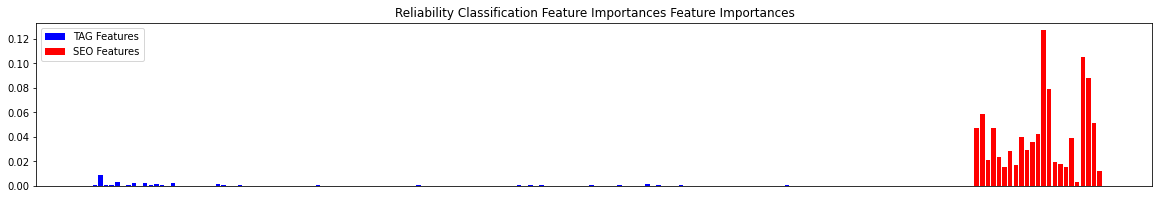

In [ ]:
import matplotlib.pyplot as plt

def plot_importances(importances, features, name):
    plt.figure(figsize=(20, 3))
    
    # Split importances and features based on your requirement
    blue_importances = importances[:159]
    red_importances = importances[159:]
    
    blue_features = features[:159]
    red_features = features[159:]

    # Create blue bars
    plt.bar(range(len(blue_features)), blue_importances, color='blue', tick_label=blue_features, label='TAG Features')

    # Create red bars
    plt.bar(range(len(blue_features), len(features)), red_importances, color='red', tick_label=red_features, label='SEO Features')

    # Disable xticks
    plt.xticks([])

    # Set title and legend
    plt.title(name + ' Feature Importances')
    plt.legend()
    plt.savefig('feature_importances.png', bbox_inches='tight', dpi=300)
    plt.show()

rf_classifier = RandomForestClassifier()
train_data = df_combined.drop(columns=['label','0'])
rf_classifier = rf_classifier.fit(train_data, df_combined['label'])
features = X_train.columns
plot_importances(rf_classifier.feature_importances_, features, 'Reliability Classification Feature Importances')
